# Install packages

In [ ]:
!pip install hdbscan
!pip install kmedoids
!pip install rdkit-pypi
!pip install yellowbrick
!pip install ipyplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039285 sha256=e97f7db2e46b416a0d0a5e826b42e1ca0fd0ff29923a94c5d7db73fa56464461
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/

# 4.1 Loading wwl distance matrix

In [ ]:
import numpy as np
# Here is the best iteration I selelcted
wwl_d_6 = np.load('/content/wasserstein_distance_matrix_it6.npy')

# 4.2 seed selection of tsne (for projection)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X= wwl_d_6
seed= np.arange(1, 50)
log=[]
for i in seed:
  test = TSNE(n_iter=500, metric='precomputed', init='random', random_state=i).fit(X)
  log.append(test.kl_divergence_)
best= np.argmax(np.array(log))

print('best KL div: {result}'.format(result= log[best]))
print('best_seed: {seed}'.format(seed= seed[best]))

# 4.3 Kmeans

In [ ]:
#Ref: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


X= wwl_d_6
projection = TSNE(metric='precomputed', init='random',  random_state=8).fit_transform(X)
range_n_clusters= list(int(i) for i in range(10,51))

for n_clusters in range_n_clusters:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, n_init=1, random_state=13)
  cluster_labels = clusterer.fit_predict(X)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(X, cluster_labels)
  print(
      "For n_clusters =",
      n_clusters,
      "The average silhouette_score is :",
      silhouette_avg,
  )

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(
      *projection.T, marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
  )
  ax2.set_title("The TSNE visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(
      "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
      % n_clusters,
      fontsize=14,
      fontweight="bold",
  )

plt.show()

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
X=wwl_d_6
model = KMeans(n_init=1, random_state=13)
# Ref: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html#yellowbrick.cluster.elbow.KElbowVisualizer
# The K-Elbow Visualizer implements the “elbow” method of selecting the optimal number of clusters for K-means clustering.
# If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k.
visualizer = KElbowVisualizer(model, k=(10,51))

visualizer.fit(X)
visualizer.show()

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans

df= pd.read_csv('/content/eli_duplcate_hf.csv')
smiles, target= df['smiles'], df['half_life']
kmeans= KMeans(n_clusters=26, n_init=1, random_state=13).fit(X)
kmean_df= pd.DataFrame()
kmean_df['smiles'], kmean_df['half_life'], kmean_df['cluster_label']= smiles, target, kmeans.labels_
kmean_df.to_csv('kmean_df.csv', index=False)

cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(cluster_sizes)
print(cluster_ids)

# 4.4 HDBSCAN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hdbscan import hdbscan, HDBSCAN
from hdbscan.flat import HDBSCAN_flat, approximate_predict_flat, membership_vector_flat, all_points_membership_vectors_flat
from sklearn.manifold import TSNE
from mpl_toolkits.axisartist.axislines import Subplot
%matplotlib inline

X= wwl_d_6
projection= TSNE(n_iter=500, metric='precomputed', init='random', random_state=8).fit_transform(X)
sc=np.arange(6, 50, 1)

for c in sc:
  #The primary parameter to effect the resulting clustering is min_cluster_size. Ideally this is a relatively intuitive parameter to select
  #set it to the smallest size grouping that you wish to consider a cluster.
  clusterer = HDBSCAN(metric="precomputed", cluster_selection_method="eom", min_cluster_size=c).fit(X)
  labels = clusterer.labels_
  cluster_ids, cluster_sizes = np.unique(labels, return_counts=True)
  print(f"Number of elements assigned to each cluster in {c}: {cluster_sizes}")
  proba = clusterer.probabilities_
  # A score of how persistent each cluster is. Using this parameter to select best min_cluster_size
  #A score of 1.0 represents a perfectly stable cluster that persists over all distance scales, while a score of 0.0 represents a perfectly ephemeral cluster.
  print(clusterer.cluster_persistence_)
  fig, ax = plt.subplots()

  fig.suptitle('TSNE plot of HDBSCAN clustering result', fontweight ="bold")

  plt.scatter(project[labels>=0, 0], project[labels>=0, 1], c=labels[labels>=0], s=5, cmap=plt.cm.jet)
  plt.scatter(project[labels<0, 0], project[labels<0, 1], c='k', s=3, marker='x', alpha=0.2)
  print(f"Unique labels (-1 for outliers): {np.unique(labels)}")

  ax.set_xlabel("Feature space for the 1st feature")
  ax.set_ylabel("Feature space for the 2nd feature")
  plt.show()

In [ ]:
import pandas as pd

df= pd.read_csv('/content/eli_duplcate_hf.csv')
smiles, target= df['smiles'], df['half_life']
clusterer = HDBSCAN(metric="precomputed", cluster_selection_method="eom", min_cluster_size=10).fit(X)
hdbscan_df= pd.DataFrame()
hdbscan_df['smiles'], hdbscan_df['half_life'], hdbscan_df['cluster_label']= smiles, target, clusterer.labels_
hdbscan_df.to_csv('hdbscandf.csv', index=False)

cluster_ids, cluster_sizes = np.unique(clusterer.labels_, return_counts=True)
print(cluster_sizes)
print(cluster_ids)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
wwl_d_6 = np.load('/content/wasserstein_distance_matrix_it6.npy')
X= wwl_d_6
projection= TSNE(n_components=2, n_iter=500, metric='precomputed', init='random', random_state=8).fit_transform(X)

df= pd.read_csv('/content/hdbscandf.csv')
labels = df['cluster_label']
cluster_ids, cluster_sizes = np.unique(labels, return_counts=True)
df2 = pd.DataFrame()
df2["y"] = labels
df2["Feature space for the 1st feature"] = projection[:,0]
df2["Feature space for the 2nd feature"] = projection[:,1]
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.scatterplot(x="Feature space for the 1st feature", y="Feature space for the 2nd feature", hue=df2.y.tolist(),
                palette= sns.color_palette("hls", len(cluster_ids)),
                data= df2).set(title="TSNE plot of HDBSCAN clustering result")

# 4.5 Kmedoids

In [ ]:
import kmedoids
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

X=wwl_d_6
c= np.arange(10, 51, 1, dtype=int)
algo=['fasterpam', 'fastermsc', 'fastpam1']
seed=[103, 109, 135]

for a, s in zip(algo, seed):
  kk_lb=[]
  kk_ind=[]
  kk_iner=[]
  kk_ms=[]

  for i in c:
    #print(i)
    kk= kmedoids.KMedoids(n_clusters= int(i), metric='precomputed', metric_params=None, method=a, init='random', max_iter=300, random_state=int(s))
    k6= kk.fit(wwl_d_6)
    k6p= kk.fit_predict(wwl_d_6)
    kk_lb.append(k6p)
    kk_ind.append(k6.medoid_indices_)
    km_ms = kmedoids.medoid_silhouette(X, k6.medoid_indices_)
    #print(km_ms[0])
    kk_ms.append(km_ms[0])
    #print(k6.inertia_)
    kk_iner.append(k6.inertia_)

  # The clusters in optimal k are assumed to have the smallest inertia; conversely, the Medoid Silhouette should be as near to 1 as possible.
  # we plot average score curve(inertia and medoid_silhouette) first, and the best k should be the point of inflection on the average score curve,
  x1 = list(c)
  y1 = kk_ms
  plt.plot(x1, y1, color='red', linestyle="-", linewidth="2", markersize="16", marker=".", label="medoid_silhouette_score")
  # MinMaxScale for better visualization
  scler= MinMaxScaler()
  kch= np.array(kk_iner).reshape(-1, 1)
  y2 = scler.fit_transform(kch)
  plt.plot(x1, y2, color='blue', linestyle="-", linewidth="2", markersize="16", marker=".", label="minMaxscale_kmedoids_inertia")
  plt.xlim(10, 50)
  plt.ylim(np.min(y2)-0.25, np.max(y2)+0.25)

  plt.xlabel('cluster_n', fontsize="10")
  plt.ylabel('value', fontsize="10")
  plt.title(f'Kmedoids_{a} clustering', fontsize="18")

  plt.legend()
  plt.show()

In [ ]:
import pandas as pd
import kmedoids
X=wwl_d_6
df= pd.read_csv('/content/eli_duplcate_hf.csv')
smiles, target= df['smiles'], df['half_life']
km_m = kmedoids.KMedoids(17, metric='precomputed', method='fastermsc', init='random', random_state=109)
km_m.fit(X)
fastermsc= pd.DataFrame()
fastermsc['smiles'], fastermsc['half_life'], fastermsc['cluster_label']= smiles, target, km_m.labels_
fastermsc.to_csv('fastermsc.csv', index=False)

cluster_ids, cluster_sizes = np.unique(km_m.labels_, return_counts=True)
print(cluster_sizes)
print(cluster_ids)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
wwl_d_6 = np.load('/content/wasserstein_distance_matrix_it6.npy')
X= wwl_d_6
projection= TSNE(n_components=2, n_iter=500, metric='precomputed', init='random', random_state=8).fit_transform(X)
df= pd.read_csv('/content/fastermsc.csv')

labels = df['cluster_label']
cluster_ids, cluster_sizes = np.unique(labels, return_counts=True)
df2 = pd.DataFrame()
df2["y"] = labels
df2["Feature space for the 1st feature"] = projection[:,0]
df2["Feature space for the 2nd feature"] = projection[:,1]
fig, ax = plt.subplots()
fig.set_size_inches(9, 7)
sns.scatterplot(x="Feature space for the 1st feature", y="Feature space for the 2nd feature", hue=df2.y.tolist(),
                palette= sns.color_palette("hls", len(cluster_ids)),
                data= df2).set(title="TSNE plot of FasterMSC clustering result")

# 4.6 Plot structures

In [ ]:
import pandas as pd

kmean_df= pd.read_csv('/content/kmean_df.csv')

MCS1 contains 7 atoms and 6 bonds.
MCS SMARTS string: [#7]-,:[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]
MCS1 contains 10 atoms and 9 bonds.
MCS SMARTS string: [#6](-,:[#7]-,:[#6]:,-[#6]:,-[#6])-,:[#6]-,:[#6]-,:[#6]:,-[#6]:,-[#6]
MCS1 contains 8 atoms and 7 bonds.
MCS SMARTS string: [#6]:,-[#7]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]:,-[#6]
MCS1 contains 6 atoms and 5 bonds.
MCS SMARTS string: [#6](:,-[#6]:,-[#6]:,-[#6]):,-[#6]:,-[#6]
MCS1 contains 5 atoms and 4 bonds.
MCS SMARTS string: [#6](-,:[#7]-,:[#6]-,:[#6]):,-[#6]


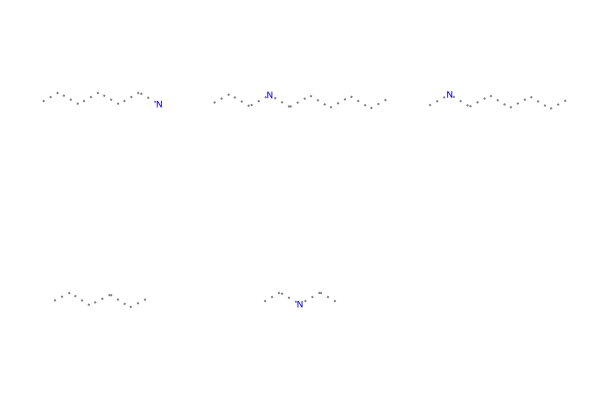

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from PIL import Image
from typing import List, Tuple, Union
%matplotlib inline

# Here is an example of kmeans for demonstration, these clusters are minor classes tempted to be potenial outliers
kcluster_12= kmean_df[kmean_df['cluster_label'] == 12]
kcluster_13= kmean_df[kmean_df['cluster_label'] == 13]
kcluster_18= kmean_df[kmean_df['cluster_label'] == 18]
kcluster_23= kmean_df[kmean_df['cluster_label'] == 23]
kcluster_24= kmean_df[kmean_df['cluster_label'] == 24]

mol12 = [Chem.MolFromSmiles(i) for i in kcluster_12['smiles']]
mol13 = [Chem.MolFromSmiles(i) for i in kcluster_13['smiles']]
mol18 = [Chem.MolFromSmiles(i) for i in kcluster_18['smiles']]
mol23 = [Chem.MolFromSmiles(i) for i in kcluster_23['smiles']]
mol24 = [Chem.MolFromSmiles(i) for i in kcluster_24['smiles']]


k_mols = [mol12, mol13, mol18, mol23, mol24]


def find_save_mcs(smiles, filename):
  k_m=[]
  for i in smiles:
    # find MCS of each group
    mcs1 = rdFMCS.FindMCS(i)
    print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
    print("MCS SMARTS string:", mcs1.smartsString)
    m1 = Chem.MolFromSmarts(mcs1.smartsString)
    k_m.append(m1)
    img= Draw.MolToImage(m1, legend="MCS1")
  k_img = Draw.MolsToGridImage(k_m)
  png = k_img.data
  with open(f'{filename}.png','wb+') as outf:
    outf.write(png)

  return k_m



k_m= find_save_mcs(k_mols, 'kmeans_mcs')
#open the MCS image just saved
Image.open('/content/kmeans_mcs.png')

In [ ]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdFMCS
from matplotlib.colors import ColorConverter
import ipyplot

highlightColor= ColorConverter().to_rgb('turquoise')

def plot_mcs_on_compounds(smiles, mcs)
  for mol, mcs in zip(smiles, mcs):
    imglist=[]
    for i in mol:
      img= Draw.MolToImage(i, highlightAtoms=i.GetSubstructMatch(mcs), highlightBonds=i.GetSubstructMatch(mcs), highlightColor=highlightColor)
      imglist.append(img)
    ipyplot.plot_images(imglist, img_width=150)

plot_mcs_on_compounds(k_mols, k_m)

Output hidden; open in https://colab.research.google.com to view.

# 4.7 Plot MDS plot

In [ ]:
import numpy as np
from sklearn.manifold import MDS

wwl= np.load('/content/wasserstein_distance_matrix_it6.npy')
seed=[]
sel=[]
for i in np.random.randint(1, 10000, size=300):
  np.random.seed(i)
  mds_test = MDS(n_components=2, n_jobs=-1, random_state=i, dissimilarity='precomputed')
  candidate = mds_test.fit(wwl)
  seed.append(i)
  sel.append(candidate.stress_)

ind= np.argmin(sel)
print(seed[ind])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

def plot_MDS(distance_matrix, HL_file, CL_file):

  wwl= np.load(f'{distance_matrix}')
  df1= pd.read_csv(f'{HL_file}')
  smiles= df1['SMILES']
  hf= df1['STANDARD_VALUE']
  sb= df1['TYPE']
  LT= {'unstable':0, 'moderate':1, 'stable':2}
  sbl= [ LT[i] for i in sb ]

  dic1_df1= dict(zip(smiles,hf))
  dic2_df1= dict(zip(smiles,sbl))

  df2= pd.read_csv(f'{CL_file}')
  smi= df2['smiles']
  cl= df2['cluster_label']
  dic3_df2= dict(zip(smi,cl))

  group_labels = []
  stability_labels = []
  half_life_values = []

  for i in smi:
    group_labels.append(dic3_df2[i])
    stability_labels.append(dic2_df1[i])
    half_life_values.append(dic1_df1[i])


  group_labels= np.array(group_labels)
  stability_labels= np.array(stability_labels)
  half_life_values= np.array(half_life_values)

  data = {'Group': group_labels, 'Stability': stability_labels, 'Half-Life': half_life_values}
  metadata = pd.DataFrame(data)

  # Apply MDS to the distance matrix
  mds = MDS(n_components=2, n_jobs=-1, random_state=8264, dissimilarity='precomputed')
  coordinates = mds.fit_transform(wwl)

  # Plot the MDS results with color-coded points
  plt.figure(figsize=(30, 30))

  # Scatter plot for each point in the MDS coordinates
  scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=group_labels, cmap= plt.cm.jet, s=100, alpha=0.8)

  # Add a colorbar for group labels
  plt.colorbar(scatter, label='Group Labels', ticks=np.unique(group_labels))

  for i, label in enumerate(group_labels):
      plt.annotate(str(label), (coordinates[i, 0], coordinates[i, 1]), fontsize=8, ha='center', va='center')

  # Annotate points with stability labels
  for i, stab in enumerate(stability_labels):
      plt.text(coordinates[i, 0], coordinates[i, 1], f'ST: {stab}', fontsize=8, ha='right', va='bottom')

  # Annotate points with half-life values
  #for i, hl in enumerate(half_life_values):
      #plt.text(coordinates[i, 0], coordinates[i, 1], f'HL: {hl:.2f}', fontsize=8, ha='right', va='bottom')

  # Set axis labels and show the plot
  plt.xlabel('MDS Dimension 1')
  plt.ylabel('MDS Dimension 2')
  plt.title('MDS Visualization with Additional Information')
  plt.grid(True)
  plt.show()

In [ ]:
plot_MDS('/content/wasserstein_distance_matrix_it6.npy', '/content/regression_equal_no_ion_5_smaller.csv', '/content/kmean_df.csv')

In [ ]:
plot_MDS('/content/wasserstein_distance_matrix_it6.npy', '/content/regression_equal_no_ion_5_smaller.csv', '/content/hdbscandf.csv')

In [ ]:
plot_MDS('/content/wasserstein_distance_matrix_it6.npy', '/content/regression_equal_no_ion_5_smaller.csv', '/content/fastermsc.csv')